## **3.3 - Estacionariedade**

### **O que é uma série temporal estacionária?**

Uma **série estacionária** é, intuitivamente, aquela cujo “comportamento estatístico” **não muda ao longo do tempo**: se você observar qualquer trecho da série hoje ou um trecho do mesmo tamanho daqui a um ano, as regularidades probabilísticas são as mesmas. Em termos práticos, isso significa que a série oscila em torno de um nível estável, com variabilidade típica que não se expande nem se contrai sistematicamente, e com um padrão de dependência temporal (autocorrelação) que depende apenas da **distância** entre as observações e não do **calendário** em si.

##### Definições formais

*Estacionariedade estrita (forte)*

A série $\{X_t\}$ é **estritamente estacionária** se, para quaisquer tempos $t_1,\dots,t_k$ e qualquer deslocamento $h\in\mathbb{Z}$, vale:
$$
(X_{t_1},\dots,X_{t_k})\ \stackrel{d}{=}\ (X_{t_1+h},\dots,X_{t_k+h}),
$$
isto é, **todas** as distribuições conjuntas são invariantes a translações no tempo.

*Estacionariedade fraca (de segunda ordem)*
A série $\{X_t\}$ é **fracamente estacionária** (ou covariância-estacionária) se:
1. **Média constante:** $\mathbb{E}[X_t]=\mu$ para todo $t$;
2. **Variância constante e finita:** $\operatorname{Var}(X_t)=\sigma^2<\infty$ para todo $t$;
3. **Autocovariância depende apenas do lag:** $\gamma(h)=\operatorname{Cov}(X_t,X_{t-h})$ depende de $h$ (e não de $t$).

No critério (3), $t$ é o tempo absoluto (o “calendário”) e $h$ é o lag (a distância entre duas observações). Dizer que $\gamma(h)=\operatorname{Cov}(X_t,X_{t-h})$ depende só de $h$ significa que a covariância entre dois pontos separados por $h$ passos é a mesma em qualquer posição do tempo: por exemplo, $\operatorname{Cov}(X_{100},X_{99})=\operatorname{Cov}(X_{57},X_{56})=\gamma(1)$. Isso é a essência da estacionariedade fraca: invariância temporal da média, da variância e da estrutura de dependência, esta última resumível por $\gamma(h)$ (ou pela autocorrelação $\rho(h)=\gamma(h)/\gamma(0)$) e visualizável num correlograma que não muda de forma ao longo do calendário.


### **Como verificar a estacionariedade de uma série temporal?**

Queremos determinar se uma série temporal ${X_t}$ pode ser tratada como fracamente estacionária, isto é, se possui média constante $\mathbb{E}[X_t]=\mu$, variância constante $\operatorname{Var}(X_t)=\sigma^2<\infty$ e autocovariância que depende apenas do lag $\gamma(h)=\operatorname{Cov}(X_t,X_{t-h})$. O procedimento básico começa por uma inspeção do nível da série, verificando tendência e mudanças de nível, avaliando sazonalidade (padrões calendário, como mensal ou semanal) e observando a volatilidade (se a variância aparente cresce/diminui ao longo do tempo). Evidências claras de tendência ou alterações persistentes de nível já sugerem não estacionariedade em nível.

Em seguida, analisamos os correlogramas, que são gráficos das medidas de dependência da série em função do lag (distância temporal) — tipicamente:

ACF (Autocorrelation Function): traça $\hat\rho(h)$ para $h=1,2,\dots$, mostrando o quanto $X_t$ se correlaciona com $X_{t-h}$. Em séries estacionárias, a ACF costuma decair à medida que $h$ aumenta; quando há raiz unitária, a ACF tende a decair muito lentamente ou permanecer elevada por muitos lags.

PACF (Partial ACF): mostra a correlação entre $X_t$ e $X_{t-h}$ condicionada nos lags intermediários $1,\dots,h-1$. Ela é especialmente útil após a estacionarização para sugerir ordens AR/MA.

Para interpretar correlogramas, costuma-se incluir bandas de referência (regras de bolso) em torno de zero; barras sistematicamente fora dessas bandas indicam dependências relevantes em certos lags.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Utilidades estatísticas
# --------------------------
def standardize(x, eps=1e-12):
    """Centraliza e escala para variância ~1 (facilita leitura dos gráficos)."""
    x = np.asarray(x, dtype=float)
    std = x.std(ddof=0)
    if std < eps:
        return x - x.mean()  # evita divisão por ~0
    return (x - x.mean()) / std

def acf(x, max_lag, eps=1e-12):
    """
    Autocorrelação amostral até max_lag.
    ACF(h) = gamma(h) / gamma(0),
    onde gamma(h) = (1/T) sum_t (x_t - xbar)(x_{t-h} - xbar).
    """
    x = np.asarray(x, dtype=float)
    T = len(x)
    if T < 2:
        raise ValueError("Série muito curta para ACF.")
    xbar = x.mean()
    gamma0 = np.sum((x - xbar) ** 2) / T
    if gamma0 < eps:
        # Série praticamente constante
        return np.concatenate([[1.0], np.zeros(max_lag)])

    acf_vals = [1.0]
    for h in range(1, max_lag + 1):
        cov = np.sum((x[h:] - xbar) * (x[:-h] - xbar)) / T
        acf_vals.append(cov / gamma0)
    return np.array(acf_vals)

def pacf_yw(x, max_lag, eps=1e-12):
    """
    PACF via Yule–Walker (Levinson–Durbin).
    Retorna pacf[0..max_lag], com pacf[0] = 1.
    """
    x = np.asarray(x, dtype=float)
    T = len(x)
    if T < 3:
        raise ValueError("Série muito curta para PACF.")
    x = x - x.mean()

    # autocovariâncias gamma(h), h = 0..max_lag
    gamma = np.array([np.dot(x[h:], x[:T-h]) / T for h in range(max_lag + 1)], dtype=float)

    pacf_vals = np.empty(max_lag + 1, dtype=float)
    pacf_vals[0] = 1.0

    # Arrays do algoritmo de Levinson–Durbin
    phi = np.zeros((max_lag + 1, max_lag + 1), dtype=float)
    sigma2 = np.zeros(max_lag + 1, dtype=float)

    sigma2[0] = max(gamma[0], eps)  # evita zero exato

    for k in range(1, max_lag + 1):
        if sigma2[k-1] < eps:
            # Processo degenerado numericamente
            pacf_vals[k] = 0.0
            sigma2[k] = sigma2[k-1]
            continue

        # Numerador: gamma(k) - sum_{j=1}^{k-1} phi_{k-1,j} * gamma(k-j)
        if k == 1:
            num = gamma[1]
        else:
            num = gamma[k] - np.dot(phi[k-1, 1:k], gamma[1:k][::-1])
        den = sigma2[k-1]
        phi[k, k] = num / den

        # Atualiza phi_{k,j}
        for j in range(1, k):
            phi[k, j] = phi[k-1, j] - phi[k, k] * phi[k-1, k-j]

        # Atualiza sigma^2_k
        sigma2[k] = sigma2[k-1] * max(1.0 - phi[k, k] ** 2, 0.0)
        pacf_vals[k] = phi[k, k]

    return pacf_vals

def plot_ts(x, title):
    """Gráfico simples da série temporal."""
    plt.figure(figsize=(9, 3))
    plt.plot(x)
    plt.title(title)
    plt.xlabel("t")
    plt.ylabel("X_t")
    plt.tight_layout()
    plt.show()

def plot_correlogram(acf_vals, pacf_vals, T, max_lag, title_prefix):
    """
    Plota ACF e PACF (barras) com bandas de referência ±1.96/sqrt(T).
    Regra de bolso (não é teste formal).
    """
    band = 1.96 / np.sqrt(T)

    # ACF
    plt.figure(figsize=(9, 3))
    lags = np.arange(len(acf_vals))
    plt.stem(lags, acf_vals)  # sem use_line_collection
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.axhline(band, linestyle=":", linewidth=1)
    plt.axhline(-band, linestyle=":", linewidth=1)
    plt.xlim(-0.5, max_lag + 0.5)
    plt.title(f"{title_prefix} — ACF até lag {max_lag}")
    plt.xlabel("lag h")
    plt.ylabel(r"$\hat{\rho}(h)$")
    plt.tight_layout()
    plt.show()

    # PACF
    plt.figure(figsize=(9, 3))
    lags = np.arange(len(pacf_vals))
    plt.stem(lags, pacf_vals)  # sem use_line_collection
    plt.axhline(0, linestyle="--", linewidth=1)
    plt.axhline(band, linestyle=":", linewidth=1)
    plt.axhline(-band, linestyle=":", linewidth=1)
    plt.xlim(-0.5, max_lag + 0.5)
    plt.title(f"{title_prefix} — PACF até lag {max_lag}")
    plt.xlabel("lag h")
    plt.ylabel("PACF(h)")
    plt.tight_layout()
    plt.show()

# --------------------------
# Gerando séries de exemplo
# --------------------------
rng = np.random.default_rng(42)
T = 500

# Série 1: Estacionária AR(1): X_t = 0.6 X_{t-1} + e_t
phi = 0.6
e = rng.normal(0, 1, size=T)
x_ar1 = np.zeros(T)
for t in range(1, T):
    x_ar1[t] = phi * x_ar1[t-1] + e[t]
x_ar1 = standardize(x_ar1)

# Série 2: Não estacionária — random walk com drift: X_t = X_{t-1} + c + e_t
c = 0.05
e2 = rng.normal(0, 1, size=T)
x_rw = np.zeros(T)
for t in range(1, T):
    x_rw[t] = x_rw[t-1] + c + e2[t]
x_rw = standardize(x_rw)  # apenas para comparar em escala similar nos gráficos

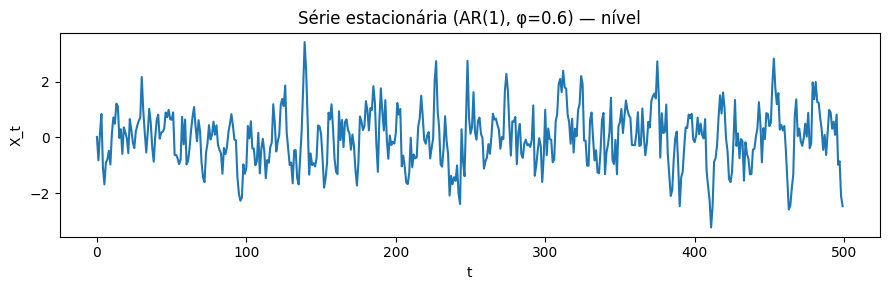

Figura 1 — Série estacionária (AR(1), ϕ = 0.6):
- A série oscila em torno de um nível constante, sem tendência persistente.
- A variabilidade parece estável ao longo do tempo (sem mudanças claras de escala).
- Esse comportamento é compatível com estacionariedade em nível.


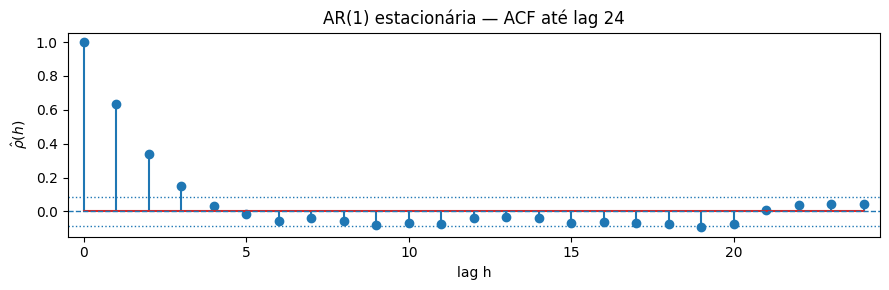

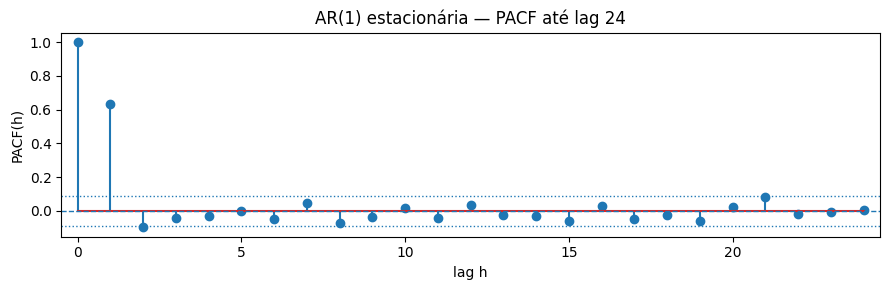


Figura 2 — AR(1): ACF até lag 24:
- A ACF começa alta no lag 1 e DECRESCE rapidamente conforme o lag aumenta.
- Esse decaimento aproximadamente geométrico é típico de AR(1) estacionário (ρ(h) ≈ ϕ^h).
- Poucas barras cruzam as bandas de referência: dependência cai rápido → sinal de estacionariedade.

Figura 3 — AR(1): PACF até lag 24:
- Pico predominante em lag 1 e, em seguida, valores próximos de zero.
- Padrão clássico de PACF para um processo AR(1): ‘corte’ (ou pico dominante) em 1.


In [ ]:
# --------------------------
# Correlogramas
# --------------------------
max_lag = 24

# AR(1)
plot_ts(x_ar1, "Série estacionária (AR(1), φ=0.6) — nível")
print("Figura 1 — Série estacionária (AR(1), ϕ = 0.6):")
print("- A série oscila em torno de um nível constante, sem tendência persistente.")
print("- A variabilidade parece estável ao longo do tempo (sem mudanças claras de escala).")
print("- Esse comportamento é compatível com estacionariedade em nível.")

plot_correlogram(acf_ar1, pacf_ar1, T, max_lag, "AR(1) estacionária")
acf_ar1 = acf(x_ar1, max_lag)
print("\nFigura 2 — AR(1): ACF até lag 24:")
print("- A ACF começa alta no lag 1 e DECRESCE rapidamente conforme o lag aumenta.")
print("- Esse decaimento aproximadamente geométrico é típico de AR(1) estacionário (ρ(h) ≈ ϕ^h).")
print("- Poucas barras cruzam as bandas de referência: dependência cai rápido → sinal de estacionariedade.")

pacf_ar1 = pacf_yw(x_ar1, max_lag)
print("\nFigura 3 — AR(1): PACF até lag 24:")
print("- Pico predominante em lag 1 e, em seguida, valores próximos de zero.")
print("- Padrão clássico de PACF para um processo AR(1): ‘corte’ (ou pico dominante) em 1.")

---

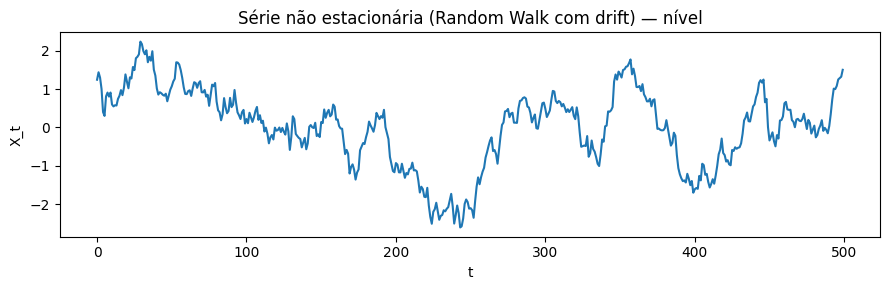


Figura 4 — Random Walk com drift: série em nível:
- Caminho ‘vagante’ com tendência/deriva e longos períodos acima/abaixo do nível anterior.
- A variância aparente cresce com o tempo (não há retorno claro a um nível fixo).
- Esse aspecto visual sugere NÃO estacionariedade em nível (raiz unitária).


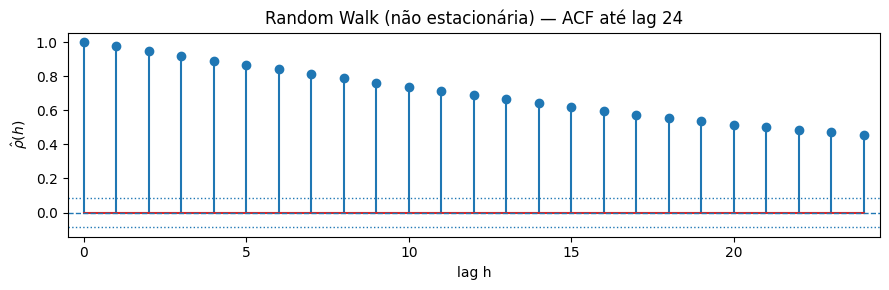

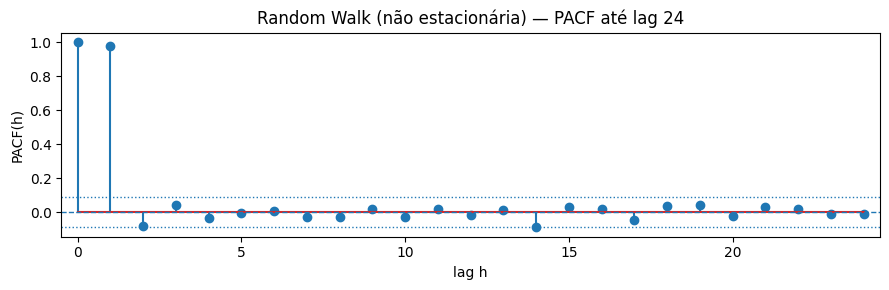


Figura 5 — Random Walk: ACF até lag 24:
- A ACF fica MUITO alta em muitos lags e decai muito lentamente.
- Padrão típico de processos com raiz unitária (não estacionários): forte ‘arrasto’ de autocorrelação.
- Muitas barras ultrapassam as bandas de referência por vários lags.

Figura 6 — Random Walk: PACF até lag 24:
- Pico forte em lag 1 e, depois, valores pequenos/irregulares.
- Esse comportamento, combinado com a ACF que decai muito lentamente, é consistente com raiz unitária.


In [ ]:
# --------------------------
# Correlogramas
# --------------------------

# Random walk
plot_ts(x_rw, "Série não estacionária (Random Walk com drift) — nível")
print("\nFigura 4 — Random Walk com drift: série em nível:")
print("- Caminho ‘vagante’ com tendência/deriva e longos períodos acima/abaixo do nível anterior.")
print("- A variância aparente cresce com o tempo (não há retorno claro a um nível fixo).")
print("- Esse aspecto visual sugere NÃO estacionariedade em nível (raiz unitária).")


acf_rw = acf(x_rw, max_lag)
pacf_rw = pacf_yw(x_rw, max_lag)
plot_correlogram(acf_rw, pacf_rw, T, max_lag, "Random Walk (não estacionária)")
print("\nFigura 5 — Random Walk: ACF até lag 24:")
print("- A ACF fica MUITO alta em muitos lags e decai muito lentamente.")
print("- Padrão típico de processos com raiz unitária (não estacionários): forte ‘arrasto’ de autocorrelação.")
print("- Muitas barras ultrapassam as bandas de referência por vários lags.")

print("\nFigura 6 — Random Walk: PACF até lag 24:")
print("- Pico forte em lag 1 e, depois, valores pequenos/irregulares.")
print("- Esse comportamento, combinado com a ACF que decai muito lentamente, é consistente com raiz unitária.")

***Antes de prosseguir:** como este é um curso introdutório e ainda **não** vimos inferência estatística, vale reservar um tempo para revisar rapidamente: **hipótese nula e alternativa**, **nível de significância**, **valor-$p$** e **poder do teste**. Procure, por exemplo, “testes de hipótese estatística”, “valor-$p$ em termos práticos” e “erro tipo I/II”. Esse pano de fundo ajuda a interpretar corretamente os resultados que vêm a seguir.*

Se quisermos validar formalmente a estacionariedade ou não estacionariedade de uma série, devemos recorrer a alguns testes estatísticos. A ideia dos testes é simples: cada um coloca uma “história padrão” para a série e pergunta se os dados são **compatíveis** com essa história.

- **ADF/PP (Augmented Dickey–Fuller / Phillips–Perron)** 
   
  **História padrão (hipótese nula $H_0$):** a série **tem raiz unitária** → **não** é estacionária em nível (ex.: comporta-se como um *random walk*).  
  **Como ler:** se o teste **rejeita $H_0$**, os dados **não** parecem um random walk ⇒ **evidência a favor de estacionariedade** (ou de uma série que, após pequenos ajustes determinísticos, fica estacionária).

- **KPSS (Kwiatkowski–Phillips–Schmidt–Shin)**  

  **História padrão ($H_0$):** a série **é estacionária** (em torno de um nível ou de uma tendência determinística).  
  **Como ler:** se o teste **rejeita $H_0$**, os dados **não** parecem estacionários ⇒ **evidência contra estacionariedade**.

***Regras de bolso para conciliar resultados*** 

- **ADF/PP rejeitam** e **KPSS não rejeita** → **suporte para estacionariedade**.  
- **ADF/PP não rejeitam** e **KPSS rejeita** → **provável não estacionariedade**.  
- Conflitos → reexaminar gráficos, sazonalidade, possíveis quebras e a **especificação do teste**.

*O que pesquisar (sugestões de estudo rápido)*

- “Teste **ADF** — interpretação e exemplos”  
- “Teste **Phillips–Perron** — ideia e diferenças para ADF”  
- “Teste **KPSS** — estacionariedade em torno de nível/tendência”  
- “Diferença entre **raiz unitária** e **tendência determinística**”  
- “Como escolher **constante** e **tendência** em testes de raiz unitária”

Com essa base, você conseguirá interpretar os testes com segurança e decidir, de forma mais objetiva, se a série pode ser tratada como estacionária (ou quais transformações aplicar antes de modelar).